In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
from flows.models import VARmodel
import flows
from flows import parametrized as fp

import numpy as np
import pandas as pd
from tensorflow.contrib.distributions import WishartCholesky
import math
from tqdm import tqdm
import pickle as pkl

np.random.seed(1234)
tf.set_random_seed(1234)

ccodes = ['AUS', 'FRA', 'GBR']
datas = ['./CDATA/{}.csv'.format(x) for x in ccodes]

datas = [pd.read_csv(x, index_col='VARIABLE').iloc[:,:-1] for x in datas]

mean_std = 0.
for data in datas:
    std = np.std(data.values[:,1:] - data.values[:,:-1], axis=1)
    mean_std = std + mean_std
mean_std /= len(datas)
mean_std = np.concatenate([mean_std]*2, axis=0)
print('Mean std: {}'.format(mean_std))

max_year = 0
for i, data in enumerate(datas):
    data = data.astype(floatX)
    data.columns = data.columns.astype('float32')
    
    new_data = np.concatenate([data.values.T[1:], data.values.T[:-1]], axis=1)
    new_data_columns = data.columns[1:]
    new_data = pd.DataFrame(new_data.T/mean_std[:,np.newaxis], columns=new_data_columns)
    data = new_data
    datas[i] = data
    max_year = max(max(data.columns), max_year)

VAR_DIM = 4

YEARS = [x for x in data.columns if x > 2000]

country_data = {c:d for c,d in zip(ccodes, datas)}

NUM_SAMPLES=1024

#BUILDING the model

with tf.device('/cpu:0'):

    current_year = tf.placeholder(tf.float32, shape=(), name='current_year')
    tf.summary.scalar('current_year', current_year)

    with tf.variable_scope('variation_rate', dtype=floatX):
        variation_prior = tf.distributions.Exponential(rate=.3)
        dim_ = (VAR_DIM*2+1)*VAR_DIM
        variation_d = fp.pLogNormal(shape=[NUM_SAMPLES, dim_], mu=math.log(0.2), sigma=-3.)

        variation = variation_d.sample()

        pp = tf.cast(tf.reduce_sum(variation_prior.log_prob(tf.cast(variation, tf.float32)), axis=-1), floatX)
        tf.add_to_collection('priors', pp)

        tf.summary.histogram('variation', variation)
        tf.summary.scalar('mean_variation', tf.reduce_mean(variation))

    with tf.variable_scope('global_inf'):
        global_inf = DFlow([NVPFlow(dim=(VAR_DIM*2+1)*VAR_DIM, name='flow_{}'.format(i), aux_vars=tf.log(variation)) for i in range(8)], 
                            init_sigma=0.01, num_samples=NUM_SAMPLES)

        with tf.variable_scope('prior'):
            pmat = np.ones([VAR_DIM, VAR_DIM*2+1], dtype=floatX)
            pmat[:,:VAR_DIM] = 0.1
            pmat[:,VAR_DIM:2*VAR_DIM] = 1.
            pmat[:,-1] = 1.

            global_sigma = tf.constant(pmat.reshape(-1), dtype=floatX)[tf.newaxis]
            global_prior = Normal(None, sigma=global_sigma).logdens(global_inf.output, reduce=[-1])
        tf.add_to_collection('priors', global_prior)
        tf.add_to_collection('logdensities', global_inf.logdens)

    print('Global output: ', global_inf.output)
    print('Global logdens: ', global_inf.logdens)

    individ_variation_prior = Normal(shape=None, sigma=variation, mu=global_inf.output, name='indiv_variation_prior')

    models = []
    indivs = {}

    with tf.variable_scope(tf.get_variable_scope(), dtype=floatX, reuse=tf.AUTO_REUSE):
        for country, data in country_data.items():
            with tf.variable_scope(country):
                with tf.variable_scope('individ_variation'):
                    aux = tf.concat([global_inf.output, tf.log(variation)], axis=-1)
                    individ_variation = DFlow([NVPFlow((VAR_DIM*2+1)*VAR_DIM, 
                                                       name='nvp_{}'.format(i), 
                                                       aux_vars=aux) for i in range(8)], init_sigma=0.01, num_samples=NUM_SAMPLES)

                    ind = individ_variation.output + global_inf.output
                indivs[country] = ind

                tf.add_to_collection('logdensities', individ_variation.logdens)
                tf.add_to_collection('priors', individ_variation_prior.logdens(ind, reduce=[-1]))

            model = VARmodel(data, name='{}_model'.format(country), mu=ind[:, tf.newaxis], var_dim=VAR_DIM, current_year=current_year, num_samples=NUM_SAMPLES)
            models.append(model)
            for p in model.priors:
                tf.add_to_collection('priors', p)
            for l in model.logdensities:
                tf.add_to_collection('logdensities', l)
            print('\n')

    graph = tf.get_default_graph()

    logdensity = tf.add_n(graph.get_collection('logdensities'))
    print('logdensity: ', logdensity)

    prior = tf.add_n(graph.get_collection('priors'))
    print('prior: ', prior)

    kl = logdensity - prior
    print('KL: ', kl)
    kl = tf.reduce_mean(kl)
    kl /= 36*200*4


kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge_all()

saver = tf.train.Saver()

sess = tf.InteractiveSession()
from flows.debug import wrapper

Instructions for updating:
Use the retry module or similar alternatives.
Mean std: [0.00997741 1.20220203 0.00878533 0.04104758 0.00997741 1.20220203
 0.00878533 0.04104758]
<dtype: 'float32'>
<dtype: 'float32'>
Global output:  Tensor("global_inf/flow_7/add_3:0", shape=(1024, 36), dtype=float32, device=/device:CPU:0)
Global logdens:  Tensor("global_inf/sub:0", shape=(1024,), dtype=float32, device=/device:CPU:0)
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
ldiag logdens Tensor("AUS_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1024,), dtype=float32, device=/device:CPU:0)
<dtype: 'float32'>
Tensor("AUS_model/PWalk_prior/target:0", shape=(1024, ?, 36), dtype=float32, device=/device:CPU:0)
<dtype: 'float64'>
<dtype: 'float32'>
preds Tensor("AUS_model/strided_slice_7:0", shape=(201, 1024, 4), dtype=float32, device=/device:CPU:0)
Tensor("AUS_model/loglikelihood/strided_slice_2:0", shape=(200, 1024, 4), dtype=float32, device=/device:CPU:0)
<dtype: 'float32'>


<dtype: 'float32'

In [2]:
saver.restore(sess, './experiments/shrinkage_cond-MP-multisample/save/gvar_hier_fullcond1000-MP')

INFO:tensorflow:Restoring parameters from ./experiments/shrinkage_cond-MP-multisample/save/gvar_hier_fullcond1000-MP


In [3]:
joint = tf.stack([variation, indivs['AUS']], axis=0)

In [301]:
x = joint.eval()
for _ in range(20):
    x = np.concatenate([x, joint.eval()], axis=1)

In [302]:
x.shape

(2, 21504, 36)

In [303]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [304]:
variation

<tf.Tensor 'variation_rate/reparam_dist/sample/sample:0' shape=(1024, 36) dtype=float32>

In [341]:
xx = x[:,:,1]

In [354]:
im, xedges, yedges = np.histogram2d(np.log(xx[0]), xx[1], bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

In [355]:
def get_filter(n,k):
    ix = np.arange(-n//2,n//2, step=1)
    center = np.exp(-ix**2/20.)[:,np.newaxis].T
    return center

In [356]:
c = get_filter(10,None)

In [357]:
im = convolve2d(im, c)

c = get_filter(3,None)
im = convolve2d(im, c.T)

im /= im.sum(axis=0)[np.newaxis]

from scipy.signal import convolve2d

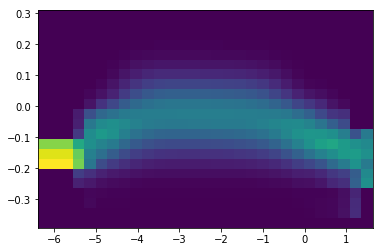

In [358]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im, extent=extent)
ax.set_aspect('auto')

In [251]:
np.log(xx[0]).mean()

-2.4825392

In [247]:
im[0,0] = 0.1

In [249]:
im[-1,0] = 0.1

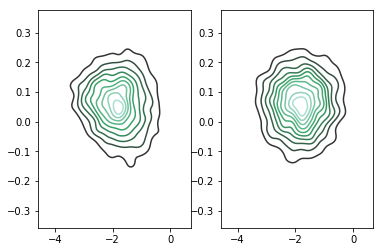

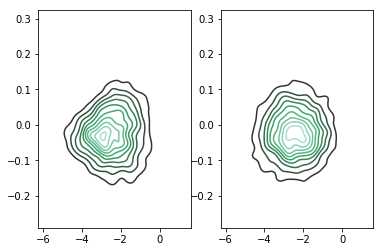

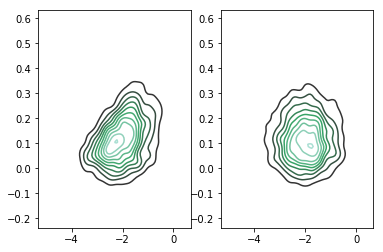

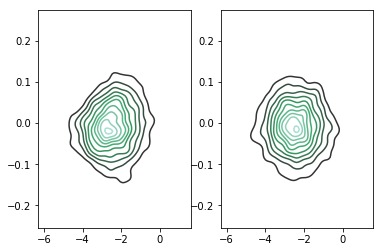

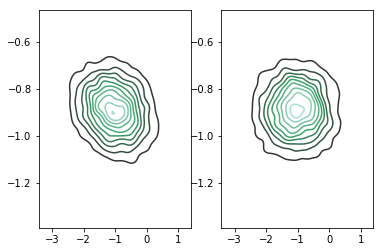

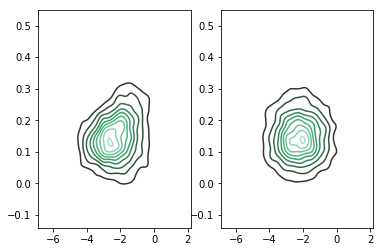

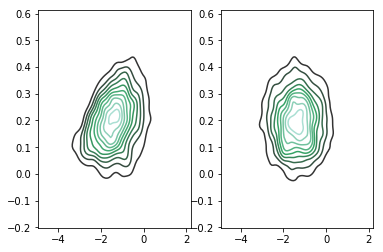

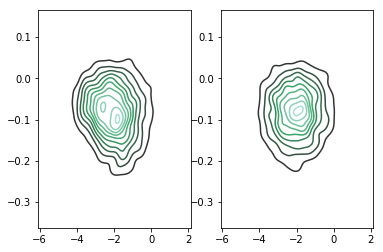

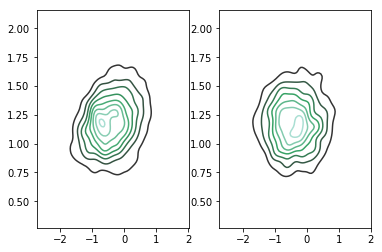

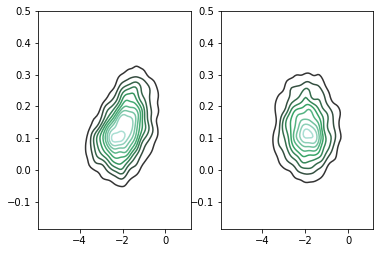

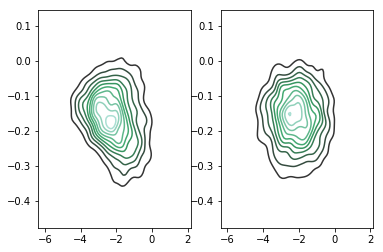

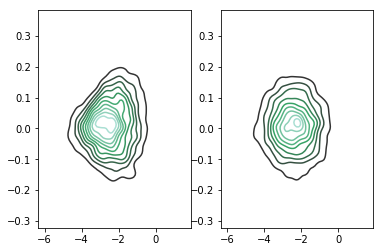

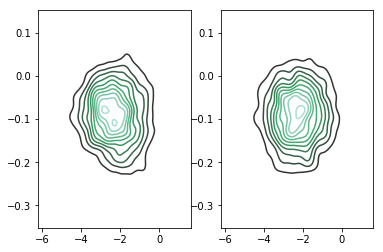

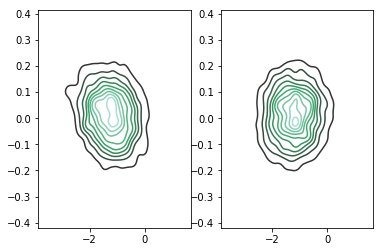

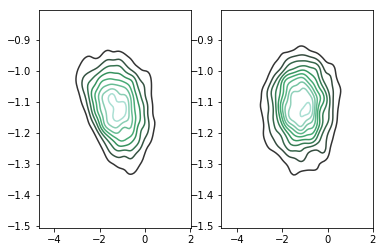

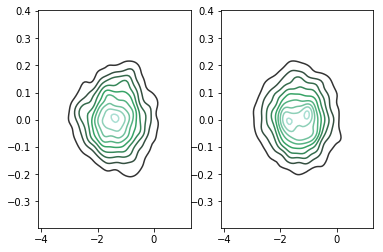

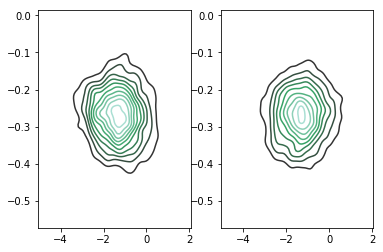

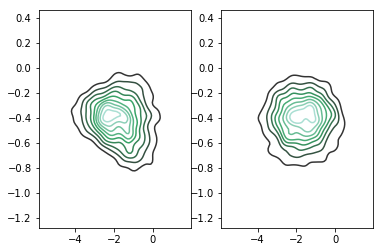

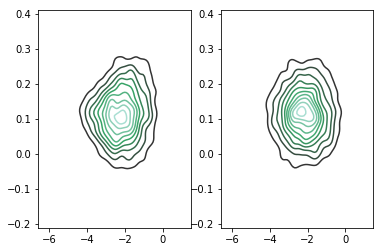

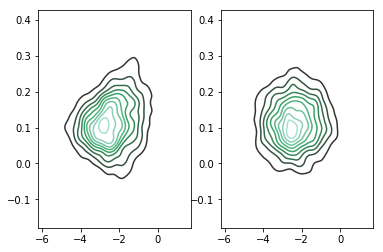

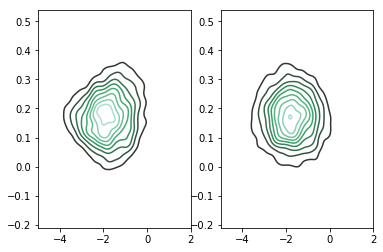

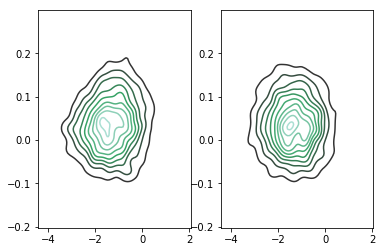

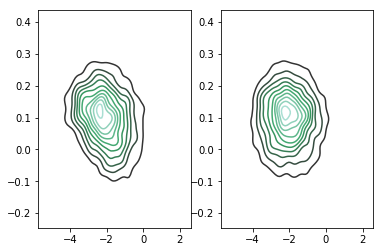

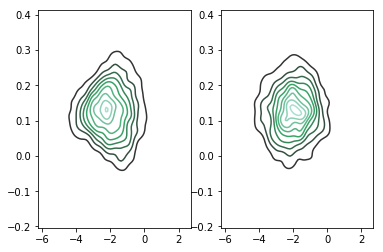

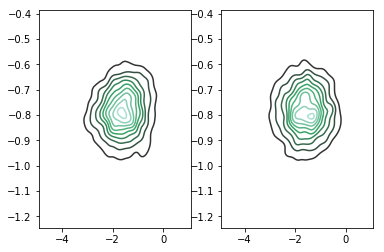

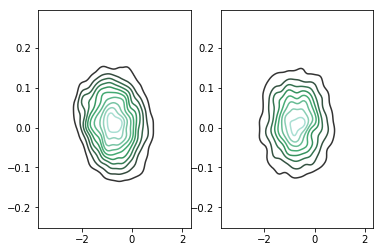

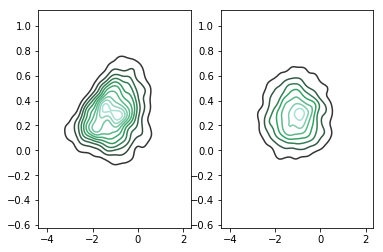

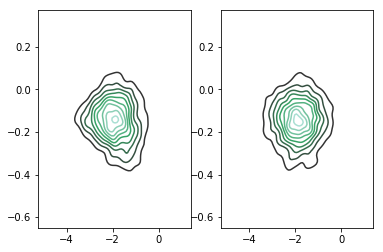

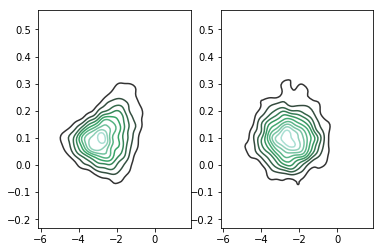

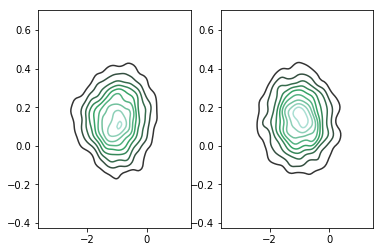

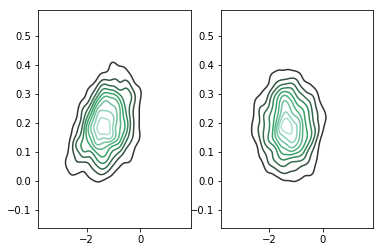

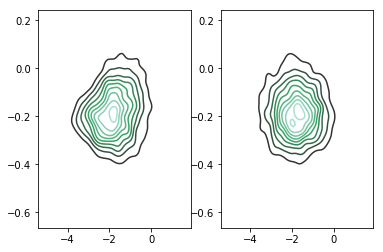

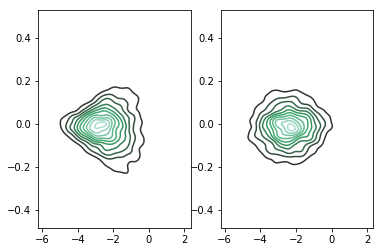

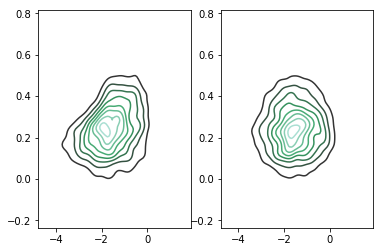

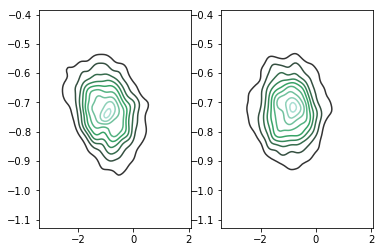

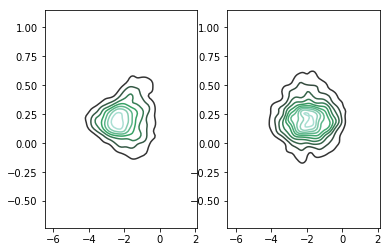

In [8]:
for i in range(x.shape[-1]):
    plt.subplot(1, 2, 1)
    sns.kdeplot(np.log(x[0,:,i]), x[1,:,i])
    var = x[0,:,i]
    np.random.shuffle(var)
    plt.subplot(1, 2, 2)
    sns.kdeplot(np.log(var), x[1,:,i])
    plt.show()

In [31]:
variation.eval().mean(axis=0)

array([0.20315865, 0.12515011, 0.16664109, 0.1360393 , 0.43576744,
       0.16034172, 0.34788862, 0.20485464, 0.7670443 , 0.2009916 ,
       0.17328165, 0.12841675, 0.1344912 , 0.34476632, 0.4036027 ,
       0.32672942, 0.3490756 , 0.27188548, 0.15184908, 0.13690038,
       0.25260866, 0.37120515, 0.20170312, 0.22675522, 0.24357334,
       0.58528215, 0.43316767, 0.18821655, 0.11878458, 0.4341808 ,
       0.3144189 , 0.23521973, 0.14318734, 0.27713442, 0.46158963,
       0.21087722], dtype=float32)

In [9]:
variation.eval().mean(axis=0)

array([0.20873676, 0.13791741, 0.17700166, 0.12867999, 0.42872825,
       0.18909788, 0.33691955, 0.2117727 , 0.78272665, 0.19679272,
       0.1888946 , 0.14094639, 0.15676895, 0.36873332, 0.42136174,
       0.3266267 , 0.4029694 , 0.3081731 , 0.16593856, 0.14516865,
       0.24750224, 0.397867  , 0.20564567, 0.24613798, 0.24732246,
       0.6391051 , 0.4923778 , 0.20425773, 0.13420743, 0.44719514,
       0.33617517, 0.2288339 , 0.17007498, 0.29783693, 0.49895644,
       0.2328836 ], dtype=float32)

In [1]:
import tensorflow as tf
from time import time

In [2]:
sess = tf.InteractiveSession()

n_ph = tf.placeholder(tf.int32, shape=())
def create_op(device, dtype):
    n = n_ph
    with tf.device(device):
        m = tf.random_normal([n,n], dtype=dtype)
        op = tf.reduce_mean(tf.matmul(m,m))
    return op

In [3]:
experiments = [(x,y) for x in ['/cpu:0', '/gpu:0'] for y in ['float32', 'float64']]
evals = {exp:create_op(*exp) for exp in experiments}

In [4]:
ns = []
results = {k:[] for k in experiments}
num_tries = 100

for n in [10, 100, 300, 400, 500, 700, 900, 1000, 1500, 2000, 3000]:
    print(n)
    for e, op in evals.items():
        t0 = time()
        for _ in range(num_tries):
            op.eval({n_ph:n})
        t1 = time()
        results[e].append(t1-t0)

10
100
300
400
500
700
900
1000
1500
2000
3000


In [5]:
results

{('/cpu:0', 'float32'): [0.03886818885803223,
  0.04386496543884277,
  0.12958550453186035,
  0.2154703140258789,
  0.4413332939147949,
  0.9020929336547852,
  1.816408395767212,
  2.3521511554718018,
  7.365610599517822,
  17.05852437019348,
  55.517590284347534],
 ('/cpu:0', 'float64'): [0.022487878799438477,
  0.04828166961669922,
  0.23168277740478516,
  0.46544623374938965,
  0.8295021057128906,
  2.105297565460205,
  4.136006832122803,
  5.486491918563843,
  17.559503078460693,
  40.26362586021423,
  130.94232153892517],
 ('/gpu:0', 'float32'): [0.1728229522705078,
  0.043412208557128906,
  0.044277191162109375,
  0.04476284980773926,
  0.04643750190734863,
  0.057473182678222656,
  0.07049107551574707,
  0.0857851505279541,
  0.21152186393737793,
  0.3665609359741211,
  1.0234317779541016],
 ('/gpu:0', 'float64'): [0.04765820503234863,
  0.05058598518371582,
  0.0874016284942627,
  0.13207268714904785,
  0.1838850975036621,
  0.4023897647857666,
  0.940779447555542,
  1.04991817

In [10]:
v

[0.03886818885803223,
 0.04386496543884277,
 0.12958550453186035,
 0.2154703140258789,
 0.4413332939147949,
 0.9020929336547852,
 1.816408395767212,
 2.3521511554718018,
 7.365610599517822,
 17.05852437019348,
 55.517590284347534]

In [14]:
from matplotlib import pyplot as plt
import numpy as np

In [11]:
ns = [10, 100, 300, 400, 500, 700, 900, 1000, 1500, 2000, 3000]

In [18]:
plots

[[<matplotlib.lines.Line2D at 0x7f9cd81042b0>],

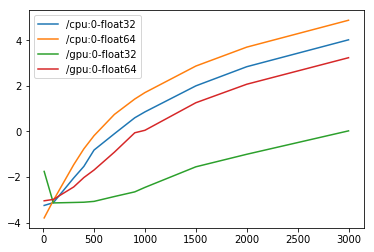

In [21]:
plots = []
for k,v in results.items():
    v = np.array(v)
    v = np.log(v)
    p = plt.plot(ns, v, label='-'.join(k))
    plots.append(p[0])
plt.legend(handles=plots)
plt.show()

In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import re
# from transliterate import translit
sess = tf.InteractiveSession()
random.seed(1234)

In [2]:
lines = []
with open('/home/nikita/tmp/compound.txt','r', errors='ignore') as f:
    for l in f:
        lines.append(l)

In [3]:
valid = ' !"()-0123456789:;.,?abcdefghijklmnopqrstuvwxyzабвгдежзийклмнопрстуфхцчшщъыьэюяё'
valid = set(valid)
lines = [[it for it in line.lower() if it in valid] for line in lines]
lines = map(lambda x: ''.join(x), lines)

In [4]:
subber = lambda x: re.sub('\s+', ' ', x)

In [5]:
lines = map(subber, lines)
lines = filter(lambda x: len(x) > 10, lines)
lines = map(lambda x: x.strip(' ').strip().lower(), lines)
new_lines = []
for line in lines:
    line = re.split('\.|,',line)
    new_lines += line

In [6]:
lines = new_lines

In [7]:
lines = map(lambda x: x.strip(' '), lines)
lines = list(filter(lambda x: len(x) > 10, lines))

In [8]:
lines[:10]

['джордж оруэлл',
 'первая часть',
 'был холодный ясный апрельский день',
 'и часы пробили тринадцать',
 'уткнув подбородок в грудь',
 'чтобы спастись от злого ветра',
 'уинстон смит торопливо шмыгнул за стеклянную дверь жилого дома победа',
 'но все-таки впустил за собой вихрь зернистой пыли',
 'в вестибюле пахло вареной капустой и старыми половиками',
 'против входа на стене висел цветной плакат']

In [9]:
# names = pd.read_csv('./all.csv')['content']
# names = names.apply(lambda x: x.split('\r\n'))

In [10]:
# names = list(names)

In [11]:
# names = sum(names, [])
# names = list(map(lambda x: x.strip(' ').lower(), names))
# names = list(filter(lambda x: len(x) > 0, names))

In [12]:
names = lines

In [13]:
# names = np.loadtxt('/home/nikita/tmp/Practical_RL/week7_[recap]_rnn/names', dtype=str, delimiter=';').tolist()

In [14]:
random.shuffle(names)

In [15]:
subber(names[4])

'чтоб не встретиться с версиловым'

In [16]:
len(names)

255541

In [17]:
chars = sorted(set(''.join(names)+'_'))
dic = {x:i for i,x in enumerate(chars)}

In [18]:
class DistLSTM:
    def __init__(self, dim, name='DistLSTM', reuse=None):
        self.dim = dim
        self.name = name
        self.reuse = reuse
        
        with tf.variable_scope(self.name, reuse=reuse):
            cells = [tf.nn.rnn_cell.LSTMCell(512, 
                                                name='cell_{}'.format(i), 
                                                activation=tf.nn.tanh) for i in range(3)]
            self.cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            self.post_cell = lambda x: self.dense(x, dim, name='d1')
            self.init_dist = tf.get_variable('init_dist',[1,dim], trainable=True,
                                             initializer=tf.random_normal_initializer(stddev=0.01, mean=0.2))
        
    def forward_string_lookup(self, strings, dic):
        inp = strings
        
        forward_lookup = tf.py_func(lambda x: self._convert_to_ix(x, dic), [inp], tf.int64)
        forward_lookup = tf.reshape(forward_lookup, (-1,))
        forward_lookup = tf.nn.embedding_lookup(tf.diag(tf.ones(len(chars))), forward_lookup)
        forward_lookup = tf.reshape(forward_lookup, [tf.shape(inp)[0], -1, len(chars)])
        forward_lookup = tf.cast(forward_lookup, tf.float32)
        return forward_lookup
    
    def dense(self, inp, dim, name='dense'):
        with tf.variable_scope(name, initializer=tf.random_normal_initializer(stddev=0.01)):
            W = tf.get_variable('W', [inp.shape[-1], dim])
            b = tf.get_variable('b', [1, dim])
            out = tf.matmul(inp, W) + b
        return out
    
    def logdens(self, seq):
        with tf.variable_scope(self.name, reuse=self.reuse):
            batch_size, s_len = tf.shape(seq)[0], tf.shape(seq)[1]

            cell = self.cell

            s_t = tf.transpose(seq, [1,0,2])
            init_state = cell.zero_state(batch_size=batch_size, dtype=tf.float32)

            init = (tf.zeros([batch_size, cell.state_size[0][0]]), init_state)
            out,_ = tf.scan(lambda prev, x: cell(x, prev[1]), s_t, initializer=init)
            out = tf.transpose(out, [1,0,2])
            
            out_dim = out.shape
            
            out = tf.reshape(out, [-1, out_dim[-1]])
            out = self.post_cell(out)
            out = tf.reshape(out, [batch_size, s_len, self.dim])
            
            preds = out[:,:-1]
            target = seq[:,1:]
                        
            init_logits = tf.tile(self.init_dist, [batch_size,1])
            init_nll = tf.nn.softmax_cross_entropy_with_logits_v2(labels=seq[:,0], logits=init_logits)
            init_nll = init_nll[:,tf.newaxis]
            
            nll = tf.nn.softmax_cross_entropy_with_logits_v2(labels=target, logits=preds)
            nll = tf.concat([init_nll, nll], axis=1)
            return -nll
        
    def sample(self):
        with tf.variable_scope(self.name, reuse=self.reuse):
            init_sample = tf.distributions.Multinomial(total_count=1., logits=self.init_dist).sample()
            
            cell = self.cell

            init_state = cell.zero_state(batch_size=1, dtype=tf.float32)

            init = (init_sample, init_state)
            
            def step(prev):
                x = prev[0]
                state = prev[1]
                cell_step = cell(x, state)
                post_step = self.post_cell(cell_step[0])
                post_step = tf.distributions.Multinomial(total_count=1., logits=post_step).sample()
                return post_step, cell_step[1]
            
            out,_ = tf.scan(lambda prev, _: step(prev), tf.range(40), initializer=init)
            out = tf.transpose(out, [1,0,2])
            out = tf.concat([init_sample[:,tf.newaxis,:], out], axis=1)
            return out                
            
    def backward_string_lookup(self, encs, dic):
        encs = tf.cast(encs, tf.bool)
        strs = tf.py_func(lambda x: self._convert_from_enc(x, dic), [encs], tf.string)
        return strs
        
    @staticmethod
    def _convert_to_ix(names, dic):
        if type(names[0]) != str:
            names = list(map(lambda x: x.decode('utf-8'), names))
        chars = []
        max_len = max([len(x) for x in names])
        filler = dic['_']
        for name in names:
            chars.append([])
            for s in name:
                chars[-1].append(dic[s])
            chars[-1] += [filler]*(max_len-len(name))
        return np.array(chars)
    
    @staticmethod
    def _convert_from_enc(encs, dic):
        rev_dic = {i:x for x,i in dic.items()}
        ret = []
        for row in encs:
            table = np.array([range(len(dic))]*len(row))
            ixs = table[row]
            chars = [rev_dic[ix] for ix in ixs]
            string = ''.join(chars)
            ret.append(string)
            print(string)
        return np.array(ret)

In [19]:
len(names)

255541

In [20]:
train = names[:230000]
test = names[230000:]

In [21]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(np.array(train))
    test_data = tf.data.Dataset.from_tensor_slices(np.array(test))
    test_data = test_data.shuffle(1000).repeat().batch(200)
    test_sampler = test_data.make_one_shot_iterator()

In [22]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(np.array(train))
    train_data = train_data.shuffle(1000).repeat().batch(200)
    train_sampler = train_data.make_one_shot_iterator()

In [23]:
with tf.device('/cpu:0'):
    train_sample = train_sampler.get_next()
    test_sample = test_sampler.get_next()

In [24]:
with tf.device('/cpu:0'):
    dlstm = DistLSTM(len(chars), reuse=tf.AUTO_REUSE)

In [25]:
with tf.device('/cpu:0'):
    fwd_lk = dlstm.forward_string_lookup(train_sample, dic)

    fwd_lk_test = dlstm.forward_string_lookup(test_sample, dic)

    train_loss = -tf.reduce_mean(dlstm.logdens(fwd_lk))

    test_loss = -tf.reduce_mean(dlstm.logdens(fwd_lk_test))

In [26]:
with tf.device('/cpu:0'):
    sample = dlstm.sample()
    reconstr = dlstm.backward_string_lookup(sample, dic)

In [27]:
# !rm -R /tmp/tfdbg

In [28]:
train_sum = tf.summary.scalar('train_loss', train_loss)
tf.summary.scalar('test_loss', test_loss)
summary = tf.summary.merge_all()
!mkdir /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg/cpu')

mkdir: cannot create directory ‘/tmp/tfdbg’: File exists


In [29]:
with tf.device('/cpu:0'):
    opt = tf.train.AdamOptimizer(0.0002).minimize(train_loss)

In [30]:
tf.global_variables_initializer().run()

In [31]:
ss = sample.eval()
dlstm._convert_from_enc(ss.astype('bool'), dic)

4ыц 0ul1h3г1бу"lmхtt-4ххкfьяс6tq(ajcъiъqc


array(['4ыц 0ul1h3г1бу"lmхtt-4ххкfьяс6tq(ajcъiъqc'], dtype='<U41')

In [ ]:
for epoch in range(1000):
    for batch in range(400):
        opt.run()
        if batch % 5 == 0:
            s = train_sum.eval()
            writer.add_summary(s, global_step=epoch*400 + batch)

    s = summary.eval()
    writer.add_summary(s)
    
    ss = sample.eval()
    dlstm._convert_from_enc(ss.astype('bool'), dic)

In [29]:
saver = tf.train.Saver()

In [30]:
saver.save(sess, '/tmp/save')

INFO:tensorflow:Restoring parameters from /tmp/save
